In [1]:
install.packages("data.table")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [1]:
library(data.table)

In [2]:
df <- fread("/media/igna/Data/CRI_IA/Teacher_to_teacher/all_text_data.csv", header = T, sep = ',')

In [3]:
str(df)

Classes ‘data.table’ and 'data.frame':	676757 obs. of  11 variables:
 $ V1           : int  0 1 2 3 4 5 6 7 8 9 ...
 $ author       : chr  "blanc78" "Yaka..." "elodieh" "cdkm" ...
 $ comment_text : chr  "['Bonjour ', 'Je cherche une séance de depart pour introduire la representation des nombres sur une droite grad"| __truncated__ "['Comment abordez-vous la symétrie en cm1?', \"\"Je suis étonnée, je n'ai pas trouvé de post là-dessus pour le "| __truncated__ "[\"\"Moi aussi je vais commencer la symétrie vendredi ca m'interesse aussi...\"\", \"\"Même si je pense commenc"| __truncated__ "['en principe la symétrie a été vue en CE1 et en CE2 ....vous pouvez commencer par une situation problème simpl"| __truncated__ ...
 $ date_message : chr  "2010-02-23T16:46:05Z" "2010-02-10T17:36:40Z" "2010-02-21T11:39:24Z" "2010-02-21T11:52:19Z" ...
 $ nb_messages  : chr  "18 messages" "3 517 messages" "73 messages" "662 messages" ...
 $ quoted_people: chr  "[]" "[]" "[]" "['elodieh']" ...
 $ quoted_text 

In [4]:
df[,comment_text:=tolower(comment_text)]
df[,date:=as.POSIXct(date_message)]
df[,year:=year(date)]
df[,week:=week(date)]

**To do:**
- Adding to the query the forum name and issue
- Adding to the plot the moment of the year and the holiday dates each year

In [11]:
dall <- as.data.frame(df[,.N, by=.(year,week)])
dchs <- as.data.frame(df[comment_text %like% "math",.N, by=.(year,week)])

In [13]:
dpl <- merge(x = dall, y = dchs, by = c("year","week"), all.x = TRUE)

In [16]:
names(dpl)

[1] "year" "week" "N.x"  "N.y"

In [17]:
dpl$N.y[is.na(dpl$N.y)] <- 0

In [22]:
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [29]:
dpl$prop <- 100*dpl$N.y/dpl$N.x

In [25]:
names(dpl)

[1] "year" "week" "N.x"  "N.y"  "prop"

In [37]:
library(grid)
library(gridExtra)

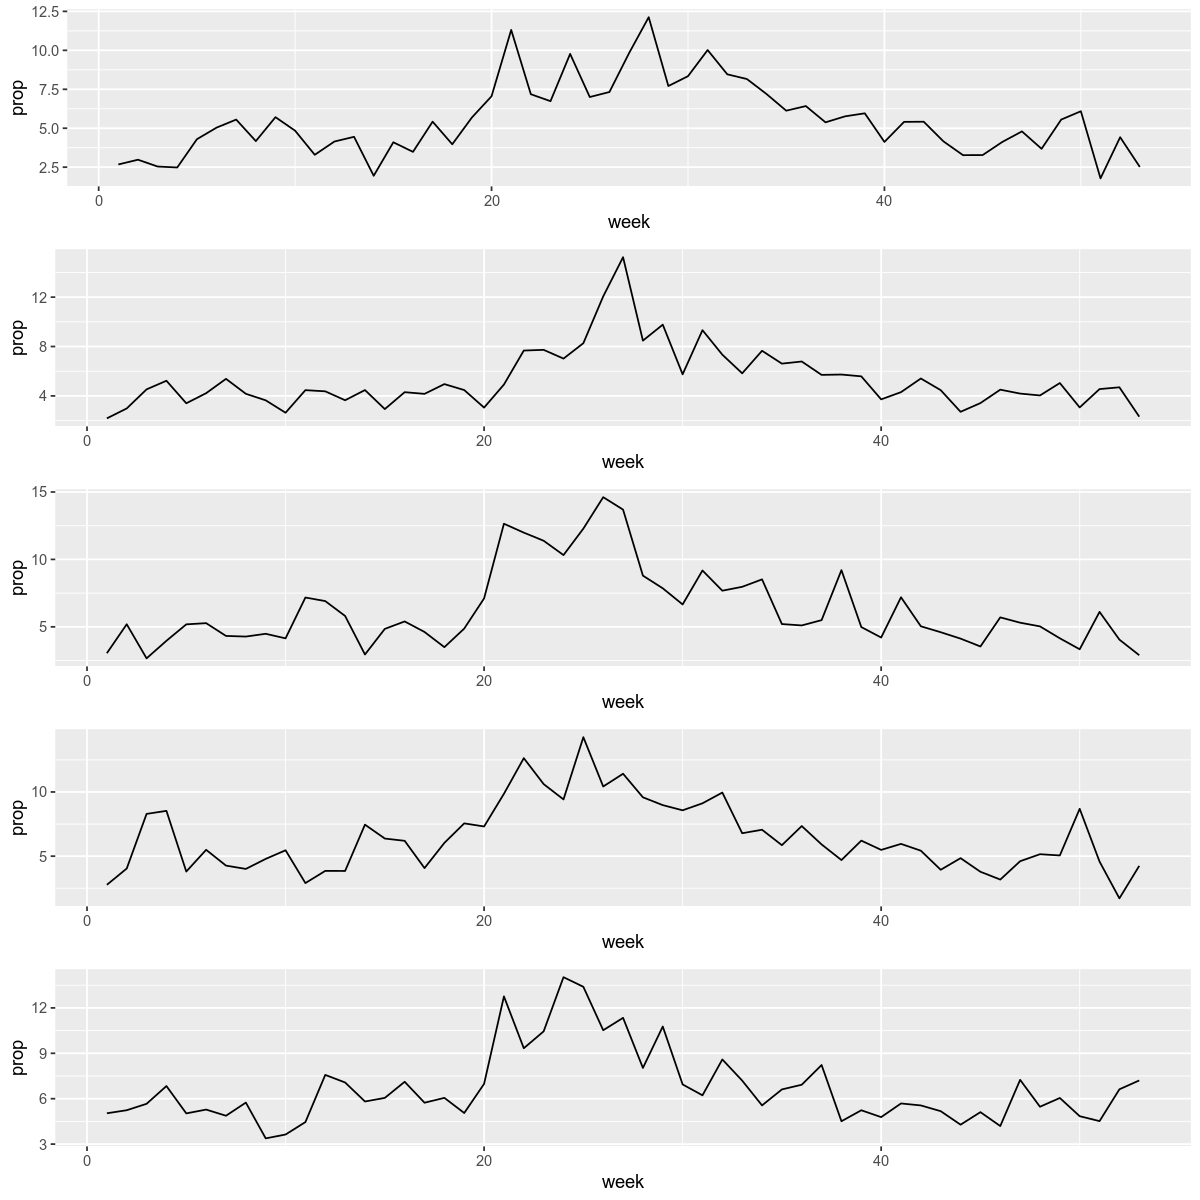

In [40]:
options(repr.plot.width=10, repr.plot.height=10)
grid.arrange(
    ggplot(data=dpl[dpl$year==2007,],aes(x=week,y=prop)) + geom_line(),
    ggplot(data=dpl[dpl$year==2008,],aes(x=week,y=prop)) + geom_line(),
    ggplot(data=dpl[dpl$year==2009,],aes(x=week,y=prop)) + geom_line(),
    ggplot(data=dpl[dpl$year==2010,],aes(x=week,y=prop)) + geom_line(),
    ggplot(data=dpl[dpl$year==2011,],aes(x=week,y=prop)) + geom_line(),
    ncol=1)

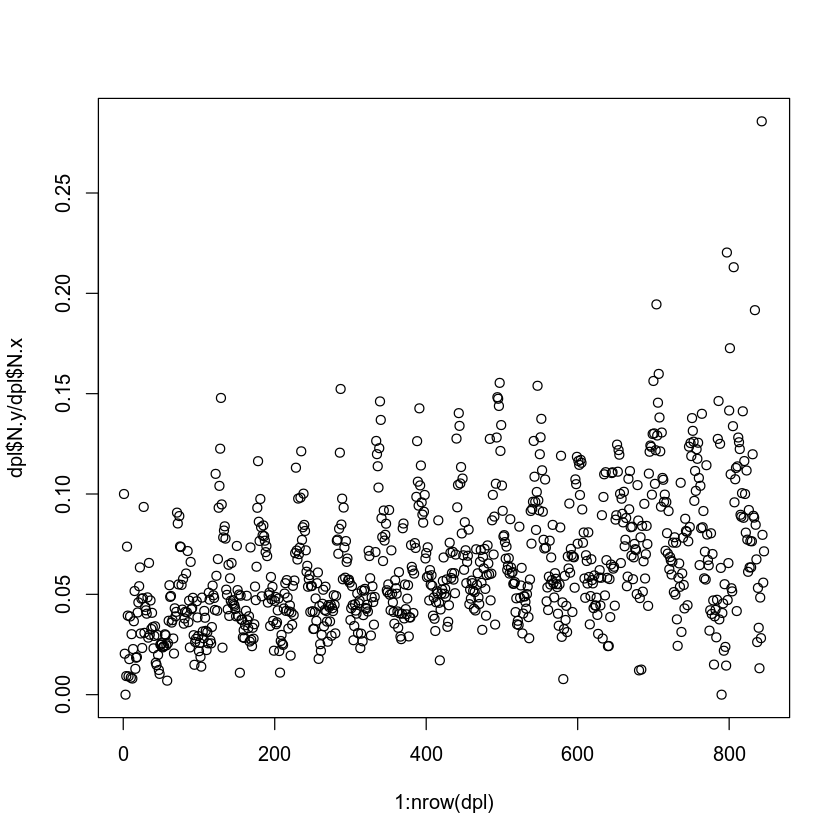

In [19]:
plot(1:nrow(dpl),dpl$N.y/dpl$N.x)

In [8]:
dim(df[comment_text %like% "math",])

[1] 45384    11

In [24]:
head(df[comment_text %like% "math",])

V1,author,comment_text,date_message,nb_messages,quoted_people,quoted_text,references,forum_name,topic_name,url_page,date,year,week
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<int>,<int>
0,blanc78,"['bonjour ', 'je cherche une séance de depart pour introduire la representation des nombres sur une droite graduée : dans pour comprendre les maths, il propose par un schema de faire faire le lien entre bande numérique et droite graduée en reportant au fur et à mesure des bandes de nombres de plus en plus grandes (ex : reporter 1, puis, 1 2 3...etc.) comment avez -vous fait ? ', 'merci']",2010-02-23T16:46:05Z,18 messages,[],[],[],Mathématiques,la droite graduée au ce1,https://forums-enseignants-du-primaire.com/topic/218867-la-droite-gradu%C3%A9e-au-ce1/?page=1,2010-02-23,2010,8
2,elodieh,"[""""moi aussi je vais commencer la symétrie vendredi ca m'interesse aussi..."""", """"même si je pense commencer par des pliages et découpage afin d'observer une symétrie par rapport à l'axe du plie?"""", 'est ce plus simple avec du calque?', 'ou peut-on directement montrer des figures papiers quadrillés et rechercher des axes de symétrie? (on peut les reproduire, les découper et les plier...)', 'bref, je suis encore dans le flou... comme toujours en maths!', """"si tu as plus d'idée yaka hésites pas ^^""""]",2010-02-21T11:39:24Z,73 messages,[],[],[],Mathématiques,Symétrie au cm1,https://forums-enseignants-du-primaire.com/topic/218033-sym%C3%A9trie-au-cm1/?page=1,2010-02-21,2010,8
33,Patty54,"['bonjour, ', """"je me pose une question concernant les tables de multiplication au ce1 : ds mon fichier de maths la table de 5 est abordée avec la table de 10, hors la table de 10 n'est pas mentionnée ds les programmes."""", """"qu'en pensez- vous?"""", 'merci par avance!']",2010-02-20T10:24:44Z,95 messages,[],[],[],Mathématiques,table de 5 et de 10 au ce1?,https://forums-enseignants-du-primaire.com/topic/218656-table-de-5-et-de-10-au-ce1/?page=1,2010-02-20,2010,8
57,Betstan,"['bonsoir,', 'je voulais savoir où vous en étiez du cap maths ce1 version 2008 et du cap maths ce2 manuel...', """"perso, en ce1, les élèves ont fait l'éval de l'unité 7 aujourd'hui (je n'ai jamais fait les pages problèmes de la fin...) et en ce2, ils en sont à la séance 5 ou 6 de l'unité 7..."""", """"merci d'avance pour vos réponses.""""]",2010-02-11T19:51:44Z,95 messages,[],[],[],Mathématiques,Où en êtes-vous? Cap maths CE1 CE2,https://forums-enseignants-du-primaire.com/topic/218113-o%C3%B9-en-%C3%AAtes-vous-cap-maths-ce1-ce2/?page=1,2010-02-11,2010,7
58,vansquale,"[""""je fais la séance 5 de l'unité 7 demain avec mes ce1."""", """"c'est vrai que ça avance lentement mais ça ne sert à rien de se précipiter"""", 'si les notions ne sont pas assimilées par les élèves. il faut donc adapter ', 'les séances (très riches) ainsi que les exercices afin que les élèves y arrivent.', """"dans ma classe il n'y a ni fichier ni manuel de maths donc ce n'est pas un problème """", """"car parfois je trouve que certains exercices s'éloignent trop des activités de"""", 'manipulation ce qui perd les gamins.']",2010-02-11T20:14:18Z,150 messages,[],[],[],Mathématiques,Où en êtes-vous? Cap maths CE1 CE2,https://forums-enseignants-du-primaire.com/topic/218113-o%C3%B9-en-%C3%AAtes-vous-cap-maths-ce1-ce2/?page=1,2010-02-11,2010,7
59,luccia,"[""""avec mes ce2 j'en suis à la séance 2 de l'unite 8."""", """"par contre à côté, j'ai déjà abordé la soustraction à retenue ainsi que la multiplication à 2 chiffres car je trouve que ça tarde dans cap math et ils étaient prêts."""", """"mais j'ai un super groupe de ce2, très travailleur et demandeur.""""]",2010-02-11T20:42:10Z,1 138 messages,[],[],[],Mathématiques,Où en êtes-vous? Cap maths CE1 CE2,https://forums-enseignants-du-primaire.com/topic/218113-o%C3%B9-en-%C3%AAtes-vous-cap-maths-ce1-ce2/?page=1,2010-02-11,2010,7


In [11]:
head(df$date_message)

[1] "2010-02-23T16:46:05Z" "2010-02-10T17:36:40Z" "2010-02-21T11:39:24Z"
[4] "2010-02-21T11:52:19Z" "2010-02-21T17:16:09Z" "2010-02-22T11:03:59Z"

In [14]:
as.POSIXct(head(df$date_message))

[1] "2010-02-23 CET" "2010-02-10 CET" "2010-02-21 CET" "2010-02-21 CET"
[5] "2010-02-21 CET" "2010-02-22 CET"

In [15]:
df[,date:=as.POSIXct(date_message)]

In [16]:
head(df$date)

[1] "2010-02-23 CET" "2010-02-10 CET" "2010-02-21 CET" "2010-02-21 CET"
[5] "2010-02-21 CET" "2010-02-22 CET"

In [20]:
strftime(head(df$date),format="%Y-%W")

 chr [1:6] "2010-08" "2010-06" "2010-07" "2010-07" "2010-07" "2010-08"


In [22]:
head(week(df$date))

[1] 8 6 8 8 8 8

In [23]:
df[,year:=year(date)]
df[,week:=week(date)]